# COVID-19 Tracking by Geographic Distance
## Clusters in the United States

For this week's exercise in K-Means clustering, I'm going to attempt to identify geographical clusters of COVID-19 cases in the United States of America. To do this, I'll be using several datasets, including The Covid-19 Tracking Project and US Census data from 2010.

First, I need to acquire my COVID-19 dataset. The columns in this dataset are self-explanatory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np


covidDF = pd.read_csv("http://covidtracking.com/api/states/daily.csv")
covidDF.head(5)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200403,AK,157.0,5859.0,NaN,NaN,15.0,NaN,NaN,NaN,...,15.0,6016,6016,6016,2,0.0,6.0,980.0,14.0,994.0
1,20200403,AL,1432.0,8187.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9619,9619,9619,1,3.0,0.0,684.0,199.0,883.0
2,20200403,AR,704.0,8995.0,NaN,71.0,NaN,NaN,NaN,26.0,...,NaN,9699,9699,9699,5,0.0,0.0,1115.0,61.0,1176.0
3,20200403,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200403,AZ,1769.0,22904.0,NaN,NaN,249.0,NaN,91.0,NaN,...,249.0,24673,24673,24673,4,9.0,21.0,1793.0,171.0,1964.0


Next, I'm going to import a dataset from the US Census that provides latitude and longitude for each state's "center of population". The center of population is the coordinate that best represents where the "balance point" for a state's population is. For example, the state of New York would have a center of population that is close to New York City, and the state of Utah would have a center of population that is close to Salt Lake City. *Note: I have downloaded this file from the Census server and manually modified it to include two-letter state codes.*

Again, the labels on this dataframe are self-explanatory.

In [2]:
popCenterDF = pd.read_csv("data/stateCentersOfPopulation2010.csv")

# merge state areas into this table
stateAreaDF = pd.read_csv("data/stateArea.csv")

stateAreaDF = stateAreaDF[['statecode', 'area']]

stateAreaDF.head()

popCenterDF = popCenterDF.join(stateAreaDF.set_index('statecode'), on='STCODE', how='right')


# remove AK, HI, and PR, just do the lower 48 + DC
popCenterDF = popCenterDF[popCenterDF['STCODE'] != 'HI']
popCenterDF = popCenterDF[popCenterDF['STCODE'] != 'AK']
popCenterDF = popCenterDF[popCenterDF['STCODE'] != 'PR']

popCenterDF['radius'] = 0.004*popCenterDF['area']/(math.pi)
popCenterDF['radius'] = popCenterDF['radius'].apply(np.sqrt)
popCenterDF.head(55)

,STATEFP,STCODE,STNAME,POPULATION,LATITUDE,LONGITUDE,area,radius
0,1,AL,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658
2,4,AZ,Arizona,6392017,33.368266,-111.864310,113990.30,12.047280
3,5,AR,Arkansas,2915918,35.142580,-92.655243,53178.55,8.228550
4,6,CA,California,37253956,35.463595,-119.325359,163694.74,14.436849
5,8,CO,Colorado,5029196,39.513420,-105.208056,104093.67,11.512436
6,9,CT,Connecticut,3574097,41.497001,-72.870342,5543.41,2.656706
7,10,DE,Delaware,897934,39.358946,-75.556835,2488.72,1.780095
9,12,FL,Florida,18801310,27.822726,-81.634654,65757.70,9.150153
10,13,GA,Georgia,9687653,33.376825,-83.882712,59425.15,8.698417
12,16,ID,Idaho,1567582,44.218532,-115.178681,83568.95,10.315197


To make plotting easier, we'll assign an x and y value to our lat/lon values using a Mercator projection.

In [3]:
# code for converting lat/lon to mercator xy coordinates copied from "Mercator projection" link below


def merc_x(lon):
  r_major=6378137.000
  return r_major*math.radians(lon)

def lat2y(a):
  return 180.0/math.pi*math.log(math.tan(math.pi/4.0+a*(math.pi/180.0)/2.0))


# dividing the x coordinate by 135000 helps eliminate stretching in our scatter plots later. 
popCenterDF['x'] = popCenterDF['LONGITUDE'].apply(merc_x)/135000
popCenterDF['y'] = popCenterDF['LATITUDE'].apply(lat2y)

popCenterDF.head(55)

,STATEFP,STCODE,STNAME,POPULATION,LATITUDE,LONGITUDE,area,radius,x,y
0,1,AL,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658,-71.538709,35.001766
2,4,AZ,Arizona,6392017,33.368266,-111.864310,113990.30,12.047280,-92.242059,35.432140
3,5,AR,Arkansas,2915918,35.142580,-92.655243,53178.55,8.228550,-76.402478,37.578991
4,6,CA,California,37253956,35.463595,-119.325359,163694.74,14.436849,-98.394357,37.972341
5,8,CO,Colorado,5029196,39.513420,-105.208056,104093.67,11.512436,-86.753387,43.078563
6,9,CT,Connecticut,3574097,41.497001,-72.870342,5543.41,2.656706,-60.088069,45.687668
7,10,DE,Delaware,897934,39.358946,-75.556835,2488.72,1.780095,-62.303321,42.878553
9,12,FL,Florida,18801310,27.822726,-81.634654,65757.70,9.150153,-67.315023,28.985418
10,13,GA,Georgia,9687653,33.376825,-83.882712,59425.15,8.698417,-69.168747,35.442389
12,16,ID,Idaho,1567582,44.218532,-115.178681,83568.95,10.315197,-94.975053,49.401259


Now, I'm going to join these two data frames by state.



In [4]:
covidDF = covidDF.join(popCenterDF.set_index('STCODE'), on='state', how='right')

covidDF.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResultsIncrease,STATEFP,STNAME,POPULATION,LATITUDE,LONGITUDE,area,radius,x,y
1,20200403,AL,1432.0,8187.0,NaN,NaN,NaN,NaN,NaN,NaN,...,883.0,1,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658,-71.538709,35.001766
57,20200402,AL,1233.0,7503.0,NaN,NaN,NaN,NaN,NaN,NaN,...,962.0,1,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658,-71.538709,35.001766
113,20200401,AL,1077.0,6697.0,NaN,NaN,NaN,NaN,NaN,NaN,...,495.0,1,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658,-71.538709,35.001766
169,20200331,AL,981.0,6298.0,NaN,NaN,NaN,NaN,NaN,NaN,...,726.0,1,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658,-71.538709,35.001766
225,20200330,AL,859.0,5694.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1563.0,1,Alabama,4779736,33.008097,-86.756826,52420.07,8.169658,-71.538709,35.001766


Now that we've loaded in all of our data, we can begin drawing our maps. For starters, we'll simply plot and label each center of population in our dataset.

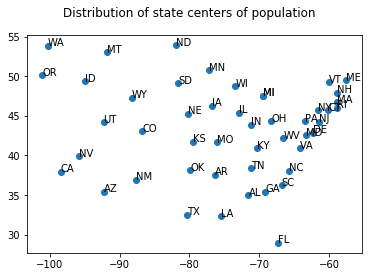

In [5]:
def AnnotateStates(pointsToAnnotate):
    plt.annotate(pointsToAnnotate['state'], (pointsToAnnotate['x'], pointsToAnnotate['y']))

plottingDF = covidDF[covidDF['date'] == 20200331][['x', 'y','state']]



plt.scatter(x=plottingDF['x'], y=plottingDF['y'])
plottingDF.apply(AnnotateStates, 1)


plt.suptitle("Distribution of state centers of population")
plt.show()

We can clearly see a shape of the continental US, with each state's population center listed.

OK, now we want to assign *each* COVID-19 case its own coordinates, based on the state radius. We'll build an entire dataframe from this.

*Note that this section is not particularly performant and should be re-designed.*

In [6]:
plottingDF = pd.DataFrame()
analysisDF = covidDF[covidDF['date'] == 20200315]


for index, row in analysisDF.iterrows():
    for individualCase in range(int(row['positive'])):
        workingRow = row.copy()
        length = np.sqrt(np.random.uniform(0, workingRow['radius']))
        angle = np.pi * np.random.uniform(0, 2)

        workingRow['x'] = workingRow['x'] + (length * np.cos(angle))
        workingRow['y'] = workingRow['y'] + (length * np.sin(angle))
        plottingDF = plottingDF.append(workingRow)


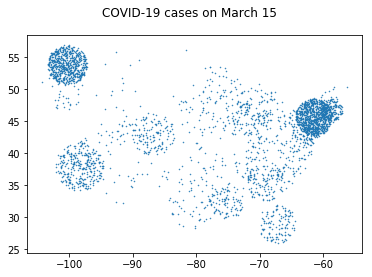

In [7]:
plt.scatter(x=plottingDF['x'], y=plottingDF['y'], marker=".", s=1)



plt.suptitle("COVID-19 cases on March 15")
plt.show()

This looks good! We can use these points to try to find clusters in our data using K-Means.

*A side note: it's pretty obvious simply by looking at this graph that there are three main clusters.  Let's see what analysis gets us.*

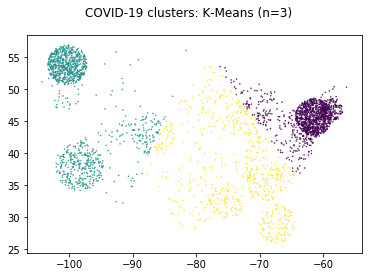

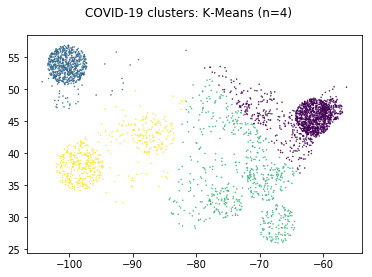

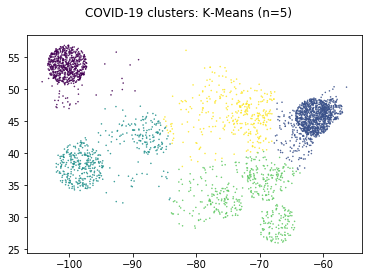

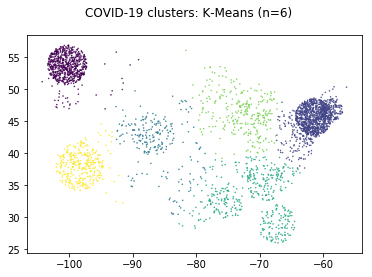

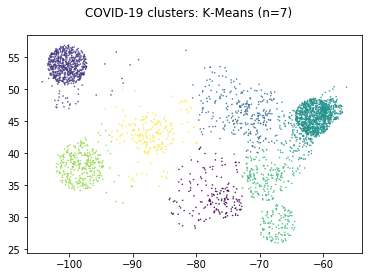

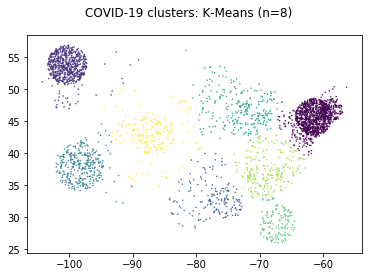

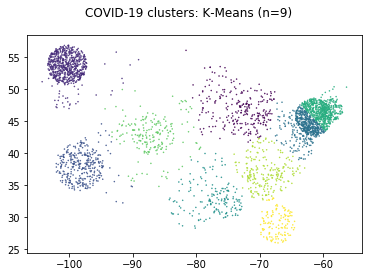

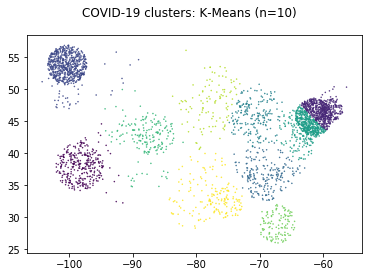

In [8]:
from sklearn.cluster import KMeans

i=0;
for i in range(3,11):

    kMeansDF = plottingDF[['x', 'y']]

    covidKMeans = KMeans(n_clusters=i, random_state=0).fit(kMeansDF)
    #print(covidKMeans.labels_)

    textLabel = "COVID-19 clusters: K-Means (n=" + str(i) + ")"

    plt.suptitle(textLabel)
    plt.scatter(plottingDF['x'], plottingDF['y'], c=covidKMeans.labels_.astype(np.float), marker=".", s=1)
    plt.show()


# Analysis

As we can see from the above graphs, there are a few possible ways that K-Means would identify clusters based on how many clusters we want. In this instance, `n=8` gives us what looks like a rational set of clusters, with areas such as New York, Washington, California, and Florida forming major clusters, while other states are distributed across four other regions, roughly definable as the Mid-Atlantic and Appalachia, the South, the Upper Midwest, and the Mountain West.


## Bibliography

The COVID Project: Historical data by state
http://covidtracking.com/api/states/daily.csv

US Census 2010 Centers of Population by State
https://www2.census.gov/geo/docs/reference/cenpop2010/CenPop2010_Mean_ST.txt

Mercator projection:
https://gis.stackexchange.com/questions/156035/calculating-mercator-coordinates-from-lat-lon]

State areas:
https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area#cite_note-2010census-2